<a href="https://colab.research.google.com/github/DenyT17/Football_Object_Detection/blob/main/Football_Object_Detection_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install ultralytics
from __future__ import annotations
import math
from typing import Generator
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import cv2 as cv
from google.colab import drive
import os
import numpy as np
%matplotlib inline
from ultralytics import YOLO
from dataclasses import dataclass, field
import math
import numpy as np
from typing import Tuple, Optional, List, Dict, Any
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
drive.mount('/content/gdrive')

ROOT_DIR = '/content/gdrive/My Drive/Football_Detection'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
model = YOLO("/content/gdrive/My Drive/Football_Detection/runs/detect/train2/weights/best.pt")

In [63]:
video = "/content/gdrive/My Drive/Football_Detection/video/Video_v0"



In [64]:
@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

@dataclass
class Detection:
    rect:Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: List[str]) -> List[Detection]:
        result = []
        for r in pred:
          boxes = r.boxes
          for box in boxes:
            class_id = int(box.cls[0])
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            result.append(Detection(
                rect=Rect(
                    x=float(x1),
                    y=float(y1),
                    width=float(x2 - x1),
                    height=float(y2 - y1)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=math.ceil((box.conf[0] * 100)) / 100
            ))
        return result
  

In [65]:
img = cv.imread("/content/gdrive/My Drive/Football_Detection/test/images/744b27_1_10_png.rf.322f9266079f0424f6aebb23c23cc6de.jpg")
prediction = model(img)
detections = Detection.from_results(
    pred=prediction,
    names=model.names)
print(detections)


0: 640x640 1 goalkeeper, 19 players, 2 referees, 1170.5ms
Speed: 1.3ms preprocess, 1170.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[Detection(rect=Rect(x=481.0, y=653.0, width=23.0, height=75.0), class_id=2, class_name='player', confidence=0.9, tracker_id=None), Detection(rect=Rect(x=871.0, y=670.0, width=26.0, height=70.0), class_id=2, class_name='player', confidence=0.9, tracker_id=None), Detection(rect=Rect(x=554.0, y=769.0, width=26.0, height=105.0), class_id=2, class_name='player', confidence=0.9, tracker_id=None), Detection(rect=Rect(x=362.0, y=757.0, width=27.0, height=98.0), class_id=2, class_name='player', confidence=0.88, tracker_id=None), Detection(rect=Rect(x=914.0, y=576.0, width=18.0, height=70.0), class_id=2, class_name='player', confidence=0.88, tracker_id=None), Detection(rect=Rect(x=610.0, y=449.0, width=14.0, height=52.0), class_id=2, class_name='player', confidence=0.87, tracker_id=None), Detection(rect=Rect(x=1001.0, y=876.0, width=24.0, height=75.0), class_id=2, class_name='player', confidence=0.87, tracker_id=None), Detection(rect=Rect(x=495.0, y=557.0, width=15.0, height=64.0), class_id=2, 

In [66]:
@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int
        
    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

def draw_shape(image: np.ndarray, rect: Rect,conf: float,name: str, color: Color, thickness: int = 2) -> np.ndarray:
  bottom_center_x = int(rect.x + rect.width/2)
  bottom_center_y = int(rect.y + rect.height)
  cv.ellipse(
      image,
      center=(bottom_center_x,bottom_center_y),
      axes=(int(rect.width), int(0.4 * rect.width)),
      angle=0.0,
      startAngle=-45,
      endAngle=235,
      color=color,
      thickness=thickness,
      lineType=cv.LINE_4
  )
  cv.putText(image, f'{name}', (max(0, int(rect.x)), max(40, int(rect.y) - 30)), 5, 1, color)
  return image

Ball_posesion_range = 30
MARKER_CONTOUR_THICKNESS = 2
MARKER_WIDTH = 20
MARKER_HEIGHT = 20
MARKER_MARGIN = 10

def calculate_marker(x: int,y:int) -> np.ndarray:
    return(np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ]))


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv.drawContours(image, [countour], 0, color, thickness)
    return image

def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv.drawContours(image, [countour], 0, color, -1)
    return image

def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection 
        in detections
        if detection.class_name == class_name
    ]

def ball_in_posesion(x_ball: int,y_ball: int, x_player: int,y_player: int, proximity: int):
  if x_player - proximity < x_ball <  x_player + proximity and y_player - proximity < y_ball <  y_player + proximity:
    return True
  else:
    return False

def get_player_in_possession(
    player_detections: List[Detection], 
    ball_detections: List[Detection],
    proximity: int) -> Optional[Detection]:
    if len(ball_detections) != 1:
        return None
    ball_detection = ball_detections[0]
    x_ball,y_ball = int(ball_detection.rect.x + ball_detection.rect.width/2),int(ball_detection.rect.y + ball_detection.rect.height)
    for player_detection in player_detections:
      x_player,y_player = int(player_detection.rect.x + player_detection.rect.width/2), int(player_detection.rect.y + player_detection.rect.height)
      if ball_in_posesion(x_ball,y_ball, x_player,y_player, proximity):
        return player_detection

def draw_marker(image: np.ndarray,x: int,y: int, color: Color) -> np.ndarray:
    possession_marker_countour = calculate_marker(x,y)

    image = draw_filled_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=color)
    image = draw_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=Ball_color,
        thickness=MARKER_CONTOUR_THICKNESS)
    return image

In [67]:
@dataclass
class BaseAnnotator:
    colors: Color
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection],player_with_posesion: Optional[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            top_center_x = int(detection.rect.x + detection.rect.width/2)
            top_center_y = int(detection.rect.y)
            annotated_image = draw_shape(
                image=image,
                rect=detection.rect,
                conf=detection.confidence,
                name=detection.class_name,
                color=self.colors[detection.class_id],
                thickness=self.thickness)
            
            
            if detection == player_with_posesion:
              annotated_image = draw_marker(
                  image=annotated_image, 
                  x=top_center_x,
                  y=top_center_y,
                  color=self.colors[detection.class_id])
        return annotated_image

def plot_image(image: np.ndarray, size: int = 12) -> None:
  plt.figure(figsize=(size, size))
  plt.imshow(image[...,::-1])
  plt.show()

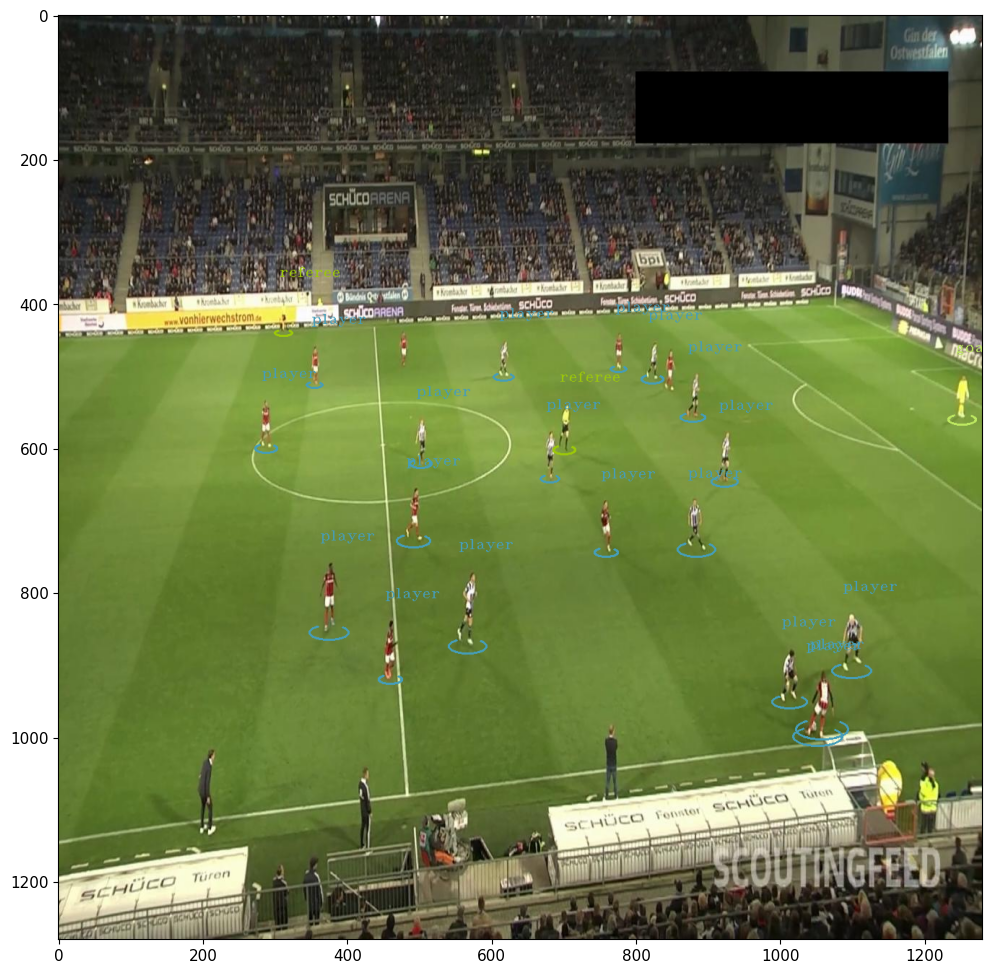

In [68]:

Ball_color = tuple(random.sample(range(0, 255), 3))
Goalkeeper_color = tuple(random.sample(range(0, 255), 3))
Players_color = tuple(random.sample(range(0, 255), 3))
Refrees_color = tuple(random.sample(range(0, 255), 3))

ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
player_detections = filter_detections_by_class(detections=detections, class_name="player")
player_in_possession_detection = get_player_in_possession(
            player_detections=player_detections,
            ball_detections=ball_detections,
            proximity=Ball_posesion_range
            )
Colors = [
    Ball_color,
    Goalkeeper_color,
    Players_color,
    Refrees_color   
]

annotator = BaseAnnotator(
    colors=Colors, 
    thickness=2)

image_with_detection = annotator.annotate(
    image=img, 
    detections=detections,
    player_with_posesion = player_in_possession_detection)

plot_image(image_with_detection)

In [28]:
def pred_and_save(video:str):
    video_path = os.path.join(f"{video}.mp4")
    video_path_out = '{}_out.mp4'.format(video)

    cap = cv.VideoCapture(video_path)
    ret, frame = cap.read()
    H, W, _ = frame.shape
    out = cv.VideoWriter(video_path_out, cv.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv.CAP_PROP_FPS)), (W, H))
    classNames = ['ball', 'goalkeeper', 'player', 'referee']
    while ret:
        prediction = model(frame)
        detections = Detection.from_results(pred=prediction,names=model.names)
        ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
        player_detections = filter_detections_by_class(detections=detections, class_name="player")
        player_in_possession_detection = get_player_in_possession(
            player_detections=player_detections,
            ball_detections=ball_detections,
            proximity=Ball_posesion_range
            )
        annotator = BaseAnnotator(colors=Colors, thickness=2)
        image_with_detection = annotator.annotate(image=frame, detections=detections,player_with_posesion = player_in_possession_detection)
        out.write(image_with_detection)
        ret, frame = cap.read()
    cap.release()
    out.release()
    cv.destroyAllWindows()
    print(f"{video_path_out} saved")

pred_and_save(video)



0: 384x640 22 players, 1 referee, 363.2ms
Speed: 3.8ms preprocess, 363.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 ball, 20 players, 1 referee, 330.4ms
Speed: 0.9ms preprocess, 330.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 players, 1 referee, 310.6ms
Speed: 0.9ms preprocess, 310.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 20 players, 1 referee, 308.8ms
Speed: 0.9ms preprocess, 308.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 ball, 20 players, 1 referee, 324.9ms
Speed: 0.9ms preprocess, 324.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 ball, 21 players, 1 referee, 337.1ms
Speed: 3.7ms preprocess, 337.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 19 players, 1 referee, 334.5ms
Speed: 0.8ms preprocess, 334.5ms inference, 0.9ms postprocess per image at shape (1, 3,

/content/gdrive/My Drive/Football_Detection/video/Video_v0_out.mp4 saved
